In [2]:
#Import Packages
##Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.signal import find_peaks

In [14]:
#Get Data
cols = ["frequency", "signal", "temp", "pressure", "excitation"]
raw_data1 = pd.read_csv("Data/GROUP4_nitrogen_widerange2.lvm", delimiter="\t", names=cols)
raw_data2 = pd.read_csv("Data/GROUP4_nitrogen_run3.lvm", delimiter="\t", names=cols)

raw_data1

,frequency,signal,temp,pressure,excitation
NaN,1000.0,0.059605,20.708908,598.409473,110.0
NaN,1011.0,0.052154,20.708801,598.451053,110.0
NaN,1022.0,0.059605,20.708526,598.417173,110.0
NaN,1033.0,0.070781,20.708359,598.403313,110.0
NaN,1044.0,0.111759,20.707855,598.384833,110.0
...,...,...,...,...,...
NaN,6456.0,12.539400,20.673614,598.118413,110.0
NaN,6467.0,11.891200,20.673203,598.138433,110.0
NaN,6478.0,11.287700,20.673523,598.143053,110.0
NaN,6489.0,10.754950,20.673462,598.135353,110.0


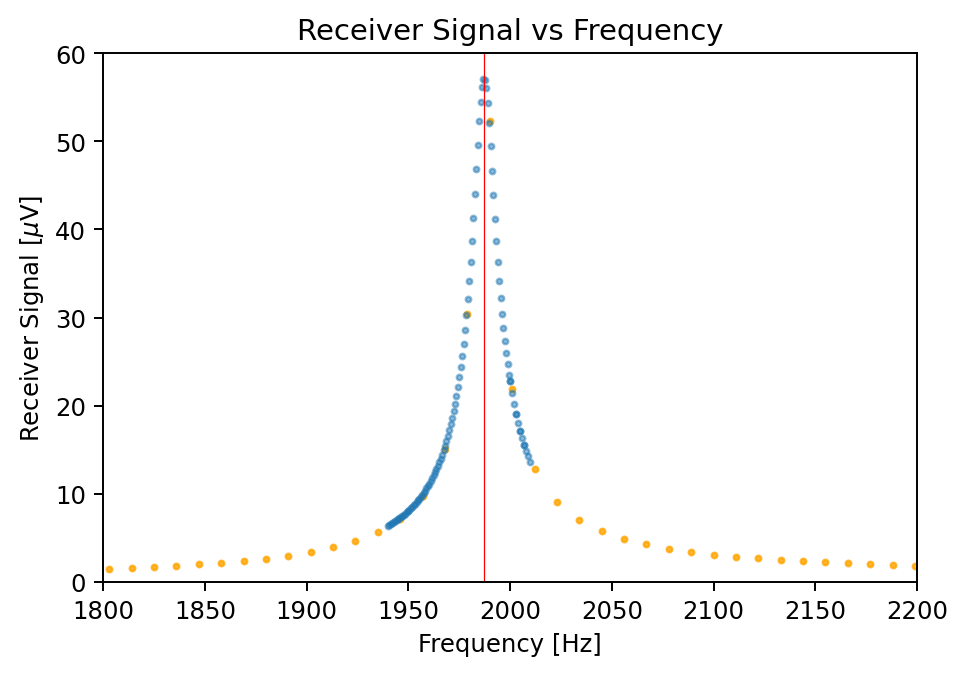

In [27]:
plt.figure(dpi=175)
plt.title("Receiver Signal vs Frequency")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Receiver Signal [$\mu$V]")


plt.scatter(raw_data1["frequency"], raw_data1["signal"], s=5, alpha=0.8, c="orange")
plt.vlines(1987, 0, 60, color="red", lw=0.5)
plt.scatter(raw_data2["frequency"], raw_data2["signal"], alpha=0.5, s=5)
plt.xlim(1800,2200)
plt.ylim(0,60)
#plt.legend()

plt.savefig("Plots/WideRange_SignalFreq.pdf")
plt.show()


[ 623.88342124 1987.31852357   10.88866372]
[1.48949469 0.0247358  0.05153605]
[0.23874568 0.00124468 0.47330004]


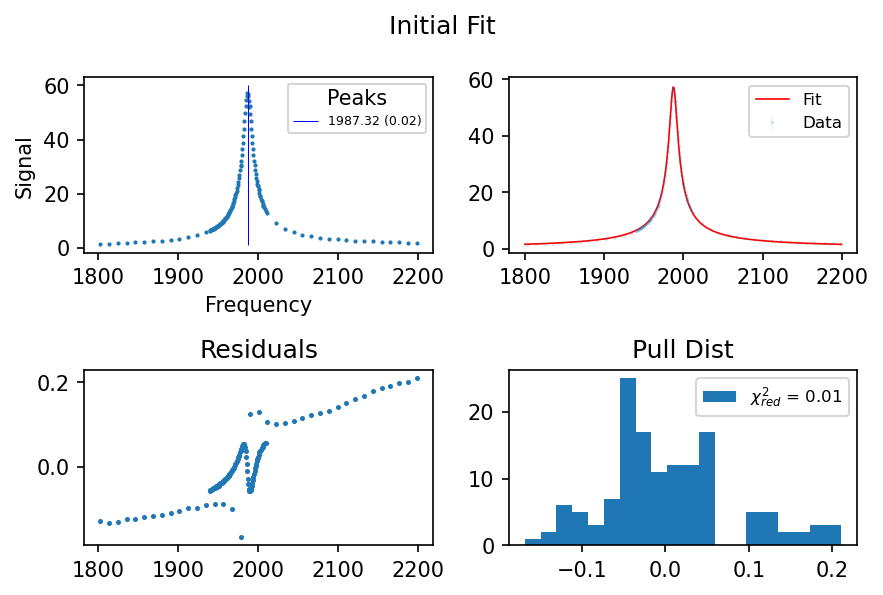

CPU times: user 520 ms, sys: 118 ms, total: 638 ms
Wall time: 655 ms


In [42]:
%%time
def gauss(x,mu=0,sigma=1):
    return np.exp(-((mu-x)**2/(2*(sigma)**2)))

def single_Gauss(x, A,mu1,sig1, d): 
    return A*gauss(x,mu1,sig1) + d

def resonance(x, A,Q,f0):
    g=x/f0
    s=(1-g**2)
    D=Q**2*s**2+g**2
    y=A*Q/D
    return y

def Resonance_New(x, A,f0,g):
    return ((A*x)/np.sqrt((x**2 - f0**2)**2 + ((g**2)*(x**2))))

func = Resonance_New

##Get Hist
plt.figure(dpi=150)
plt.suptitle(f"Initial Fit")
plt.subplot(2, 2, 1)
plt.xlabel("Frequency")
plt.ylabel("Signal")

keeps1 = (raw_data1["frequency"] > 1800) & (raw_data1["frequency"] < 2200)

frequency = np.concatenate([raw_data1["frequency"][keeps1], raw_data2["frequency"]])
signal = np.concatenate([raw_data1["signal"][keeps1], raw_data2["signal"]])

plt.scatter(frequency, signal, s=1)# lw=.8)

errors = signal**0.5

#pars, cov = scipy.optimize.curve_fit(single_Gauss, frequency.values, signal.values, #maxfev=3*10**5, sigma=errors,
#                                     p0=[3,460,20, 1],
#                                     bounds=([0.01,380,1, 0],
#                                             [5,520,200, 1.5]))
pars, cov = scipy.optimize.curve_fit(func, frequency, signal, maxfev=3*10**5, sigma=errors,
                                     p0=[3,20,1955],#, 0], #[3,460,20, 1],
                                     #bounds=([0.01,380,1, 0],
                                     #        [5,520,200, 1.5]))
                                    )
#Mean Lines
plt.vlines(pars[-2],1,60, label=f"{pars[-2]:.2f} ({np.sqrt(cov.diagonal())[-2]:.2f})", color="blue", lw=0.5)

plt.legend(title="Peaks", prop={"size":6})

#Plot Fit
plt.subplot(2, 2, 2)
x = np.arange(1800,2200,1)
#shows = (np.arange(0,len(wavelength),1)%10 == 0)

plt.errorbar(frequency, signal, yerr=errors/10, ms=.2, fmt="o", elinewidth=.1, alpha=0.5, label="Data")
plt.plot(x, func(x, *pars), color="red", lw=.8, label="Fit")
plt.legend(prop={"size":8})
#plt.xscale("log")
#plt.set_xticks(np.arange(300,901,50), minor=1)

print(pars)
print(np.sqrt(cov.diagonal()))
print(np.sqrt(cov.diagonal())/np.abs(pars)*100)

#Residuals
residuals = (signal-func(frequency, *pars))/errors
plt.subplot(2, 2, 3)
plt.title("Residuals")
plt.scatter(frequency, residuals, s=2)

#Pull Dist
plt.subplot(2, 2, 4)
plt.title("Pull Dist")
red = "{red}"
plt.hist(residuals, 20, label=f"$\chi_{red}^2$ = {np.sum(residuals**2)/len(residuals):.2f}")
plt.legend(prop={"size":8})

plt.tight_layout()
plt.savefig(f"Plots/Initial_Fit.pdf")
plt.show()